## Voy a calcular el A2 y el A1 de las componentes de Furier de la dist bidimensional de masa

#### Aca calculo el A2 pero vamos a usar en vez de binear en una esfera, vamos a binear en un cilindro (compararo los codigos barstrength2 y furier_components y además el cilindro y la esfera)

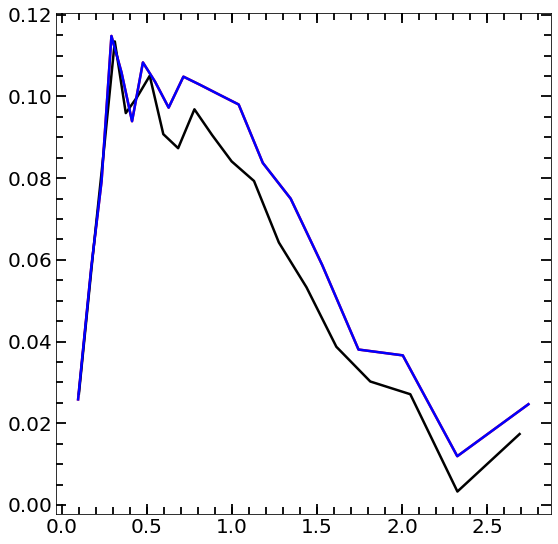

In [14]:
import numpy as np
import h5py
import rotation_mio as rot
import barstrength2 as strng
import time_conversion as tiempo
import bines2 as bines
import furier_components as fc
import matplotlib.pyplot as plt

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

vector = ('00','01','03')
vector3 = ('M31','MW','M33')
vector2= ('blue', 'red', 'green')


path = '/home/omarioni/'
atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]


path = '/mnt/is2/alejandro/ornella/'

snapshot=range(496,495,-1)
for isnap in snapshot:
    snap = h5py.File(path+'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
#     print isnap
    
    for i in range(1,2):
        cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value

        pstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Coordinates'].value
        mstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s' %vector[i])+ '/Str/Velocities'].value

        z = a0/aexp[isnap] - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        time = tiempo.conv(z, h, omega_lambda, omega_matter)
        
#---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
        ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
        zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
        r = np.sqrt(xstr**2+ystr**2+zstr**2)
         
        v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.
        
#----------------------masas----------------------------
        mstr = mstr/h
        
        r200 = r200*aexp[isnap]/h
        
        rgal=0.15*r200
        
        limit = np.where(r < rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])
        
        Mc_str = np.cumsum((mstr[limit])[r_indice])
        M_gal = Mc_str[-1]
        
#------------------ calculamos M90------------------------------------------
        razon = Mc_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)
        
        r50 = r_sort[cincuenta][-1]
#         M90 = Mc_str[noventa]                

#-------------------------------------------------------------------            
        veloc,=np.where(r<r50)
        
#----------componentes de la velocidad del centro de masa------------
        vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])
        
#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = v_x - vxcm
        vy = v_y - vycm
        vz = v_z - vzcm
        
        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz
        
        Rn = np.sqrt(xn**2. + yn**2.)
        rn = np.sqrt(xn**2. + yn**2. + zn**2.)
        
        corte,=np.where((Rn<3.*aexp[isnap]) & (zn<1.) & (zn>-1.))
        corte1,=np.where(rn<3.*aexp[isnap])
        
        A2_c, phi_c, rbin_c = strng.a2(mstr[corte], xn[corte], yn[corte], 20)
        A2_s, phi_s, rbin_s = strng.a2(mstr[corte1], xn[corte1], yn[corte1], 20)
        A2_c2, phi_c2, rbin_c2 = fc.am(mstr[corte], xn[corte], yn[corte], 20, 2)
        
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
        #                        gridspec_kw = {'height_ratios':[3,1,3,1]})
        fig.subplots_adjust(bottom=0.10, left =0.11, right = 0.97, top = 0.97)
        ax.plot(rbin_c,A2_c,'-',lw=2.5, color='r')
        ax.plot(rbin_s,A2_s,'-',lw=2.5, color='k')
        ax.plot(rbin_c2,A2_c2,'-',lw=2.5, color='b')
        
        ax.minorticks_on()
        ax.tick_params( labelsize=20)
        ax.tick_params('both', length=7,  width=1.8, which='minor', direction='in', right='on',top='on')
        ax.tick_params('both', length=10, width=1.8, which='major', direction='in', right='on',top='on')
        # plt.colorbar()
        plt.show()
        
'''LA CURVA ROJA ESTA DETRAS DE LA AZUL'''
        
#--------------------------------------------------------------------------------------------------------------------
#         path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/'
#         archivo1 =  open(path2 + str('%s'%vector3[i])+'_A2max_time_test1.dat','a')
#         archivo1.write(str('%12.6f'% time) +'\t'+
#                  str('%12.6f'% A2max) +'\t'+
#                  str('%12.6f'% phimax) +'\t'+
#                  str('%12.6f'% rmax) +'\n')
#         archivo1.close()

#archivo _new es el nuevo con las rotaciones bien hechas

#### Aca voy a calcular el A2max comparando cilindro y esfera

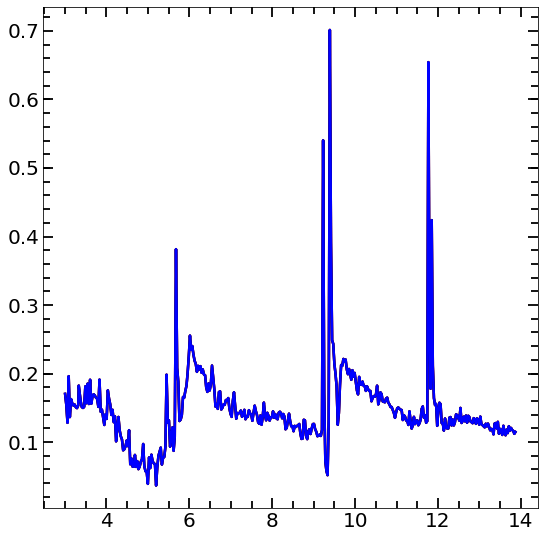

In [22]:
import numpy as np
import h5py
import rotation_mio as rot
import barstrength2 as strng
import time_conversion as tiempo
import bines2 as bines
import furier_components as fc
import matplotlib.pyplot as plt

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

vector = ('00','01','03')
vector3 = ('M31','MW','M33')
vector2= ('blue', 'red', 'green')


path = '/home/omarioni/'
atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]


path = '/mnt/is2/alejandro/ornella/'

snapshot=range(496,100,-1)

A2max_c = np.zeros(len(snapshot))
A2max_s = np.zeros(len(snapshot))
A2max_c2 = np.zeros(len(snapshot))
timev = np.zeros(len(snapshot))
j = 0

for isnap in snapshot:
    snap = h5py.File(path+'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
#     print isnap
    
    for i in range(1,2):
        cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value

        pstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Coordinates'].value
        mstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s' %vector[i])+ '/Str/Velocities'].value

        z = a0/aexp[isnap] - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        time = tiempo.conv(z, h, omega_lambda, omega_matter)
        
#---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
        ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
        zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
        r = np.sqrt(xstr**2+ystr**2+zstr**2)
         
        v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.
        
#----------------------masas----------------------------
        mstr = mstr/h
        
        r200 = r200*aexp[isnap]/h
        
        rgal=0.15*r200
        
        limit = np.where(r < rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])
        
        Mc_str = np.cumsum((mstr[limit])[r_indice])
        M_gal = Mc_str[-1]
        
#------------------ calculamos M90------------------------------------------
        razon = Mc_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)
        
        r50 = r_sort[cincuenta][-1]
#         M90 = Mc_str[noventa]                

#-------------------------------------------------------------------            
        veloc,=np.where(r<r50)
        
#----------componentes de la velocidad del centro de masa------------
        vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])
        
#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = v_x - vxcm
        vy = v_y - vycm
        vz = v_z - vzcm
        
        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz
        
        Rn = np.sqrt(xn**2. + yn**2.)
        rn = np.sqrt(xn**2. + yn**2. + zn**2.)
        
        corte,=np.where((Rn<3.*aexp[isnap]) & (zn<1.) & (zn>-1.))
        corte1,=np.where(rn<3.*aexp[isnap])
        
        A2_c, phi_c, rbin_c = strng.a2(mstr[corte], xn[corte], yn[corte], 20)
        A2_s, phi_s, rbin_s = strng.a2(mstr[corte1], xn[corte1], yn[corte1], 20)
        A2_c2, phi_c2, rbin_c2 = fc.am(mstr[corte], xn[corte], yn[corte], 20, 2)
        
        A2max_arg = np.argmax(A2_c)
        A2max_c[j]   = A2_c[A2max_arg]
#         rbinmax_c[j] = rbin_c[A2max_arg]
        
        A2max_arg = np.argmax(A2_c)
        A2max_s[j]   = A2_c[A2max_arg]
#         rbinmax_s[j] = rbin_c[A2max_arg]
        
        A2max_arg = np.argmax(A2_c)
        A2max_c2[j]   = A2_c[A2max_arg]
#         rbinmax_c2[j] = rbin_c[A2max_arg]

        timev[j] = time
        
        j = j+1
        
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.10, left =0.11, right = 0.97, top = 0.97)
ax.plot(timev,A2max_c,'-',lw=2.5, color='r')
ax.plot(timev,A2max_s,'-',lw=2.5, color='k')
ax.plot(timev,A2max_c2,'-',lw=2.5, color='b')

ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=7,  width=1.8, which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=10, width=1.8, which='major', direction='in', right='on',top='on')
# plt.colorbar()
plt.show()

#### Acá voy a calcular el A1 vs time

IndexError: index 396 is out of bounds for axis 0 with size 396

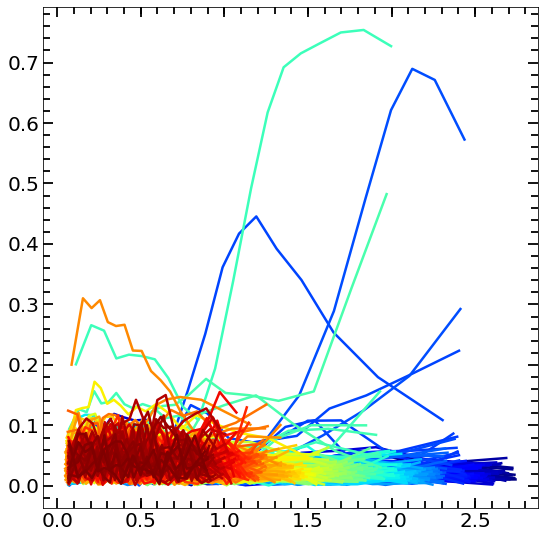

In [24]:
import numpy as np
import h5py
import rotation_mio as rot
import time_conversion as tiempo
import bines2 as bines
import furier_components as fc
import matplotlib.pyplot as plt

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

vector = ('00','01','03')
vector3 = ('M31','MW','M33')
vector2= ('blue', 'red', 'green')


path = '/home/omarioni/'
atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]


path = '/mnt/is2/alejandro/ornella/'

snapshot=range(496,100,-1)

A1max = np.zeros(len(snapshot))
timev = np.zeros(len(snapshot))
j = 0

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
colors = plt.cm.jet(np.linspace(0,1,len(snapshot)))

for isnap in snapshot:
    snap = h5py.File(path+'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
#     print isnap
    
    for i in range(1,2):
        cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value

        pstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Coordinates'].value
        mstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s' %vector[i])+ '/Str/Velocities'].value

        z = a0/aexp[isnap] - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        time = tiempo.conv(z, h, omega_lambda, omega_matter)
        
#---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
        ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
        zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
        r = np.sqrt(xstr**2+ystr**2+zstr**2)
         
        v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.
        
#----------------------masas----------------------------
        mstr = mstr/h
        
        r200 = r200*aexp[isnap]/h
        
        rgal=0.15*r200
        
        limit = np.where(r < rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])
        
        Mc_str = np.cumsum((mstr[limit])[r_indice])
        M_gal = Mc_str[-1]
        
#------------------ calculamos M90------------------------------------------
        razon = Mc_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)
        
        r50 = r_sort[cincuenta][-1]
#         M90 = Mc_str[noventa]                

#-------------------------------------------------------------------            
        veloc,=np.where(r<r50)
        
#----------componentes de la velocidad del centro de masa------------
        vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])
        
#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = v_x - vxcm
        vy = v_y - vycm
        vz = v_z - vzcm
        
        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz
        
        Rn = np.sqrt(xn**2. + yn**2.)
        rn = np.sqrt(xn**2. + yn**2. + zn**2.)
        
        corte,=np.where((Rn<3.*aexp[isnap]) & (zn<1.) & (zn>-1.))
        corte1,=np.where(rn<3.*aexp[isnap])
        
        A1, phi, rbin = fc.am(mstr[corte], xn[corte], yn[corte], 20, 1)
        
        j = j+1
        
        fig.subplots_adjust(bottom=0.10, left =0.11, right = 0.97, top = 0.97)
        ax.plot(rbin,A1,'-',lw=2.5, color=colors[j])

        ax.minorticks_on()
        ax.tick_params( labelsize=20)
        ax.tick_params('both', length=7,  width=1.8, which='minor', direction='in', right='on',top='on')
        ax.tick_params('both', length=10, width=1.8, which='major', direction='in', right='on',top='on')

plt.show()

In [ ]:
isnap = np.array([357,381,397,414,422,496]) #Gadget

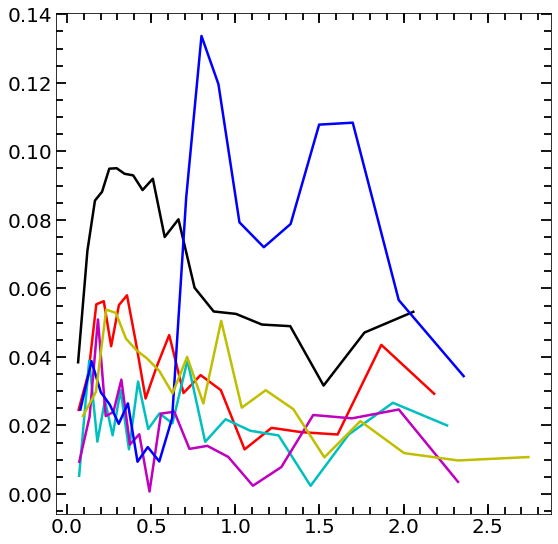

In [26]:
import numpy as np
import h5py
import rotation_mio as rot
import time_conversion as tiempo
import bines2 as bines
import furier_components as fc
import matplotlib.pyplot as plt

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

vector = ('00','01','03')
vector3 = ('M31','MW','M33')
vector2= ('blue', 'red', 'green')


path = '/home/omarioni/'
atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]


path = '/mnt/is2/alejandro/ornella/'

# snapshot=range(496,100,-1)
snapshot = np.array([357,381,397,414,422,496]) #Gadget

A1max = np.zeros(len(snapshot))
timev = np.zeros(len(snapshot))
j = 0

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
# colors = plt.cm.jet(np.linspace(0,1,len(snapshot)))
colors = ('k','r','c','m','b','y')

for isnap in snapshot:
    snap = h5py.File(path+'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
#     print isnap
    
    for i in range(1,2):
        cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value

        pstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Coordinates'].value
        mstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s' %vector[i])+ '/Str/Velocities'].value

        z = a0/aexp[isnap] - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        time = tiempo.conv(z, h, omega_lambda, omega_matter)
        
#---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
        ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
        zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
        r = np.sqrt(xstr**2+ystr**2+zstr**2)
         
        v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.
        
#----------------------masas----------------------------
        mstr = mstr/h
        
        r200 = r200*aexp[isnap]/h
        
        rgal=0.15*r200
        
        limit = np.where(r < rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])
        
        Mc_str = np.cumsum((mstr[limit])[r_indice])
        M_gal = Mc_str[-1]
        
#------------------ calculamos M90------------------------------------------
        razon = Mc_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)
        
        r50 = r_sort[cincuenta][-1]
#         M90 = Mc_str[noventa]                

#-------------------------------------------------------------------            
        veloc,=np.where(r<r50)
        
#----------componentes de la velocidad del centro de masa------------
        vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])
        
#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = v_x - vxcm
        vy = v_y - vycm
        vz = v_z - vzcm
        
        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz
        
        Rn = np.sqrt(xn**2. + yn**2.)
        rn = np.sqrt(xn**2. + yn**2. + zn**2.)
        
        corte,=np.where((Rn<3.*aexp[isnap]) & (zn<1.) & (zn>-1.))
        corte1,=np.where(rn<3.*aexp[isnap])
        
        A1, phi, rbin = fc.am(mstr[corte], xn[corte], yn[corte], 20, 1)
                
        fig.subplots_adjust(bottom=0.10, left =0.11, right = 0.97, top = 0.97)
        ax.plot(rbin,A1,'-',lw=2.5, color=colors[j])

        ax.minorticks_on()
        ax.tick_params( labelsize=20)
        ax.tick_params('both', length=7,  width=1.8, which='minor', direction='in', right='on',top='on')
        ax.tick_params('both', length=10, width=1.8, which='major', direction='in', right='on',top='on')

        j = j+1
plt.show()